import libraries

In [3]:
import pandas as pd
import json
from datetime import datetime
from collections import defaultdict
from bs4 import BeautifulSoup
import requests
import os
import re
from collections import Counter
from functools import reduce
from tqdm.notebook import tqdm
from functools import reduce
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import heapq
from itertools import product
from geopy.geocoders import Nominatim
import folium
from geopy import distance
from folium.plugins import HeatMap
import branca
import branca.colormap as cm

import custom functions

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 Data collection

## 1.1. Get the list of master's degree courses

In [ ]:
def extract_masters(this_url):
    result_url = requests.get(this_url)
    result_soup = BeautifulSoup(result_url.text, 'html.parser')
    result_links = result_soup.find_all('a', {'class': 'courseLink'})
    result_list = []
    for item in result_links:
        result_list.append(item['href'])
    return result_list

In [ ]:
# Output file path
output_file_path = 'msc_urls.txt'
# Loop through the first 400 pages and write results to the output file
with open(output_file_path, 'a') as output_file:
    for page_number in range(1, 401):
        page_url = f'https://www.findamasters.com/masters-degrees/msc-degrees/?PG={page_number}'
        page_results = extract_masters(page_url)
        for url in page_results:
            output_file.write(f'{url}\n')
        time.sleep(1)

In [ ]:
with open(output_file_path, 'r') as file:
    lines = file.readlines()
    number_of_lines = len(lines)

print(f'The file {output_file_path} contains {number_of_lines} rows.')

The file msc_urls.txt contains 6000 rows.


## 1.2. Crawl master's degree pages

In [ ]:
# Function to download HTML from a URL with prefix and save it to a file
def download_and_save_html(url, output_path):
    full_url = 'https://www.findamasters.com/' + url
    try:
        response = requests.get(full_url)
        if response.status_code == 200:
            with open(output_path, 'w', encoding='utf-8') as html_file:
                html_file.write(response.text)
        else:
            print(f"Failed to download {full_url}. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error downloading {full_url}: {e}")

# Function to create a directory if it doesn't exist
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

# Main directory for downloaded HTML files
main_directory = 'downloaded_pages'
create_directory(main_directory)

# Iterate through the URLs and download the HTML
with open('msc_urls.txt', 'r') as file:
    for index, url in enumerate(file, start=1):
        # Remove whitespaces and newline characters from the URL
        url = url.strip()

        # Generate the directory path for the current page
        page_directory = os.path.join(main_directory, f'page_{(index - 1) // 15 + 1}')
        create_directory(page_directory)

        # Generate the output HTML file path
        output_path = os.path.join(page_directory, f'course_{index}.html')

        # Download the HTML and save it to the file
        download_and_save_html(url, output_path)
        time.sleep(3)

print("Download complete for all pages.")

Download complete for all pages.


#[1.3] Parse downloaded pages



At this point, you should have all the HTML documents about the master's degree of interest, and you can start to extract specific information. The list of the information we desire for each course and their format as desiried.

#Access the stored HTML pages

In [ ]:
%pip install google-colab-shell
# import the module once
from google_colab_shell import getshell

  Preparing metadata (setup.py) ... done
  Created wheel for google-colab-shell: filename=google_colab_shell-0.2-py3-none-any.whl size=4107 sha256=80e086c86d11d45d2f29c9a491589816fae1262d0347b13dc5ea33ecab08cf12
  Stored in directory: /root/.cache/pip/wheels/f9/36/65/95dd4599be065418a9fe1f482674c8e716ce540f3f484681d2
Successfully built google-colab-shell


used command

---mettere modalità python--
git clone https://github.com/marinazanoni/nome_provvisorio.git

after accesing the repository

In [ ]:
def parser(html_page):

    # Define your default values here
    default_values = {
    'courseName': None,
    'universityName': None,
    'facultyName': None,
    'isItFullTime': None,
    'description': None,
    'startDate': None,
    'fees': None,
    'modality': None,
    'duration': None,
    'city': None,
    'administration': None,
    'country': None,
    'url': None
}

    # Create a defaultdict with default values
    info = defaultdict(lambda: default_values)

   # Extract the text (HTML)
    with open(html_page, 'r', encoding='utf-8') as file:
        html_content = file.read()
    page_soup = BeautifulSoup(html_content, 'html.parser')

    # COURSE NAME
    page_links = page_soup.find_all('h1', {'class':'text-white course-header__course-title'})
    if page_links:
        first_h1_text = page_links[0].text
        info['courseName'] = str(first_h1_text)
    #else:
        # Handle the case when no 'h1' with 'data-permutive-title' is found
    #    print("No course name found.")
    #courseName = str(first_h1_text)

    # UNIVERSITY NAME
    # Extracting our tag of interest for the Name
    page_links = page_soup.find_all('a', {'class': 'course-header__institution'})
    # Extracting the name of the course as string and print it
    info['universityName'] = str(page_links[0].contents[0])

    # FACULTY NAME
    page_links = page_soup.find_all('a', {'class': 'course-header__department'})
    info['facultyName'] = str(page_links[0].contents[0])

    # FULL TIME
    page_links = page_soup.find_all('a', {'class': 'inheritFont'})
    info['isItFullTime'] = str(page_links[0].contents[0])

    # SHORT DESCRIPTION
    page_links = page_soup.find('div', {'id': 'Snippet'})
    info['description'] = str(page_links.get_text(separator='\n').strip())

    # STARTING DATE
    page_links = page_soup.find('span', {'class': 'key-info__start-date'})
    info['startDate'] = str(page_links.get_text())

    # FEES
    page_links = page_soup.find('a', {'class': 'noWrap inheritFont'})
    page_links = page_soup.find('div', {'class': 'course-sections__fees'})
    if page_links:
        fees_text = page_links.get_text(separator='\n').strip()
        # Remove "Fees" from the text content
        info['fees'] = fees_text.replace('Fees', '').strip()


    # MODALITY
    page_links = page_soup.find('span', {'class': 'key-info__content key-info__qualification py-2 pr-md-3 text-nowrap d-block d-md-inline-block'})
    # Get all elements within the span using find_all
    elementsWithinSpan = page_links.find_all('a')
    info['modality'] = ' '.join([element.text.strip() for element in elementsWithinSpan])

    # DURATION
    page_links = page_soup.find('span', {'class':'key-info__content key-info__duration py-2 pr-md-3 d-block d-md-inline-block'})
    info['duration']=str(page_links.text)

    # CITY
    page_links = page_soup.find('a', {'class':'card-badge text-wrap text-left badge badge-gray-200 p-2 m-1 font-weight-light course-data course-data__city'})
    info['city']=str(page_links.text)

    # ADMINISTRATION
    page_links = page_soup.find('span', {'class':'course-header__online-flag badge bg-white p-2 h6 shadow-sm mr-1'})
    if page_links == None:
        info['administration'] = "On Campus"
    else:
        info['administration']=str(page_links.text)

    # COUNTRY
    page_links = page_soup.find('a', {'class':'card-badge text-wrap text-left badge badge-gray-200 p-2 m-1 font-weight-light course-data course-data__country'})
    info['country']=page_links.text

    #URL
    page_links = page_soup.find('link')
    info['url'] = page_links.get('href')


    return(pd.DataFrame([info]))


*Searching for a tipical hidden file and delete it in order not to have it when exctracting the information from the folder*

In [ ]:
parser('/content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_1/course_1.html')

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,administration,country,url
0,3D Design for Virtual Environments - MSc,Glasgow Caledonian University,School of Engineering and Built Environment,Full time,3D visualisation and animation play a role in ...,September,Please see the university website for further ...,MSc,1 year full-time,Glasgow,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...


In [ ]:
file_path_to_remove = '/content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/.DS_Store'
# Delete the hidden file
os.remove(file_path_to_remove)
print(f"The file {file_path_to_remove} has been deleted.")

In [ ]:
len(parsed_dfs)

5979

*Applying the function to our html pages*

In [ ]:
# Specifing the path of the folder
folder_path = '/content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages'

# List all files in the folder
files = os.listdir(folder_path)

parsed_dfs = []

# Iterate through all folders and subfolders using os.walk
for folder_path, _, file_names in os.walk(folder_path):
    # Check if there are files in the current folder
    if file_names:
        # Iterate through each file in the current folder
        for file_name in file_names:
            file_path = os.path.join(folder_path, file_name)

            # Store the information only is the dictionary is not empty (has at list a name course)
            try:
                # Parse the file and append the result to the list
                parsed_df = parser(file_path)
                parsed_dfs.append(parsed_df)
            except Exception as e:
                # Print the file path when an exception occurs
                print(f"Error parsing file: {file_path}")
                # print(f"Error details: {e}")

# Concatenate all DataFrames in the list
concatenated_df = pd.concat(parsed_dfs, ignore_index=True)


Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_118/course_1765.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_119/course_1772.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_128/course_1910.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_140/course_2086.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_196/course_2929.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_196/course_2931.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_215/course_3213.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_291/course_4357.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_293/course_4395.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_2

In [ ]:
concatenated_df['url'][3]

'https://www.findamasters.com/masters-degrees/course/applied-economics-banking-and-financial-markets-online-msc/?i280d8352c56675'

In [ ]:
# Display the concatenated DataFrame
concatenated_df.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,administration,country,url
0,3D Design for Virtual Environments - MSc,Glasgow Caledonian University,School of Engineering and Built Environment,Full time,3D visualisation and animation play a role in ...,September,Please see the university website for further ...,MSc,1 year full-time,Glasgow,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
1,Air Quality Solutions - MSc,University of Leeds,Institute for Transport Studies,Full time,Up to 7 million people are estimated to die ev...,September,"UK: £12,500 (Total) \nInternational: £28,750 (...",MSc,"1 year full time, 2 or 3 years part-time",Leeds,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2,Analytical Toxicology MSc,King’s College London,Faculty of Life Sciences & Medicine,Full time,The Analytical Toxicology MSc is a unique stud...,See Course,Please see the university website for further ...,MSc,Full-time: One year,London,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
3,Applied Computer Science and Artificial Inte...,University of Bradford,Faculty of Engineering & Digital Technologies,Full time,Computer science is the foundation of many exc...,"September, January",Please see the university website for further ...,MSc,1 Year Full Time / 2 Years Part Time,Bradford,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
4,Applied Economics (Banking and Financial Mar...,University of Bath,University of Bath Online,Part time,From political uncertainty to finance and recr...,"September, January",Cost per 10 credits £722* (10% alumni discount...,MSc,2 years and 6 months full time,Bath,Online,United Kingdom,https://www.findamasters.com/masters-degrees/c...


In [ ]:
concatenated_df.shape

(5979, 13)

In [ ]:
print(6000-5979, 'were not valid pages')

21 were not valid pages


In [ ]:
parsed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   courseName      1 non-null      object
 1   universityName  1 non-null      object
 2   facultyName     1 non-null      object
 3   isItFullTime    1 non-null      object
 4   description     1 non-null      object
 5   startDate       1 non-null      object
 6   fees            1 non-null      object
 7   modality        1 non-null      object
 8   duration        1 non-null      object
 9   city            1 non-null      object
 10  administration  1 non-null      object
 11  country         1 non-null      object
 12  url             1 non-null      object
dtypes: object(13)
memory usage: 232.0+ bytes


In [ ]:
# Specify the path where you want to save the .tsv file
tsv_file_path = '/content/drive/MyDrive/HM3-ADM/HW3_ADM/MasterDegrees.tsv'

# Save the DataFrame to a .tsv file
concatenated_df.to_csv(tsv_file_path, sep='\t', index=False)

print(f".tsv file saved at: {tsv_file_path}")

.tsv file saved at: /content/drive/MyDrive/HM3-ADM/HW3_ADM/MasterDegrees.tsv


### *saving singularly the information about each master (html page)*

In [ ]:
# Iterate through each DataFrame in the list
for index, parsed_df in enumerate(parsed_dfs):
    # Iterate through each row in the DataFrame
    for row_index, row in parsed_df.iterrows():
        # Replace NaN values with empty strings
        single_row = row.fillna(' ')
        # Specify the path where you want to save the .tsv file for the current row
        tsv_file_path = f'/content/drive/MyDrive/HM3-ADM/HW3_ADM/Courses/course_{index}.tsv'
        # Save the single row DataFrame to a .tsv file
        with open(tsv_file_path, 'w') as file:
            file.write('\t'.join(single_row))

#Preproccessing

Uploading the file created after parsing the information

In [5]:
df = pd.read_csv('/content/drive/MyDrive/HM3-ADM/HW3_ADM/MasterDegrees.tsv',sep='\t')
df.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,administration,country,url
0,Air Quality Solutions - MSc,University of Leeds,Institute for Transport Studies,Full time,Up to 7 million people are estimated to die ev...,September,"UK: £12,500 (Total) \nInternational: £28,750 (...",MSc,"1 year full time, 2 or 3 years part-time",Leeds,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
1,Analytical Toxicology MSc,King’s College London,Faculty of Life Sciences & Medicine,Full time,The Analytical Toxicology MSc is a unique stud...,See Course,Please see the university website for further ...,MSc,Full-time: One year,London,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2,Applied Computer Science and Artificial Inte...,University of Bradford,Faculty of Engineering & Digital Technologies,Full time,Computer science is the foundation of many exc...,"September, January",Please see the university website for further ...,MSc,1 Year Full Time / 2 Years Part Time,Bradford,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
3,Applied Economics (Banking and Financial Mar...,University of Bath,University of Bath Online,Part time,From political uncertainty to finance and recr...,"September, January",Cost per 10 credits £722* (10% alumni discount...,MSc,2 years and 6 months full time,Bath,Online,United Kingdom,https://www.findamasters.com/masters-degrees/c...
4,Applied Linguistics - MSc,University of Glasgow,College of Arts & Humanities,Full time,This Masters focuses on how linguistic researc...,September,Please see the university website for further ...,MSc,1 year full-time; 2 years part-time,Glasgow,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...


In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem import *

# Download the stopwords dataset if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#[2.0.0]

## Stemming

In [8]:
# Make a copy of the original DataFrame
processed_df = df.copy()

# stemmer
stemmer = PorterStemmer()

processed_df['description'] = processed_df.description.apply(lambda row: ' '.join([stemmer.stem(word) for word in row.split(' ')]))

##Lower, removing punctuation and stepwords

In [9]:
stop_words = set(stopwords.words('english'))

# Function to remove stopwords and punctuation from a text
def clean(text):
    """
    The following function returns the filtered element for each column of a dataframe.
    Filtering operation consists in removing punctuation and removing stopwords given text with lower case
    """
    words = word_tokenize(str(text))
    # Remove punctuation using NLTK and string.punctuation
    filtered_words = [word for word in words if word not in string.punctuation + "'’...?'+,-'‘“”„•…›✓"]
    # Remove stopwords
    filtered_words = [word for word in filtered_words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Selecting columns
text_columns = processed_df.select_dtypes(include='object').columns
# Lower
processed_df[text_columns] = processed_df[text_columns].apply(lambda x: x.str.lower() if x.dtype == 'O' else x)

# Exclude fees from removing punctuation
exclude_column = 'fees'

# Applying clean function to all the valid columns except the excluded one
processed_df[text_columns.difference([exclude_column])] = processed_df[text_columns.difference([exclude_column])].applymap(clean)


we verify which element we're filtering to check and think if something else need to be considered. Checking buy some outuput of the stemmed words we see some additional punctuation we don't want to consider which was added within the clean function.

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

We can know appreciate the differences of the two datasets (before and after preprocessing). Of our interesting will be the columns **fees** and **description**.

In [ ]:
processed_df.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,administration,country,url
0,air quality solutions msc,university leeds,institute transport studies,full time,7 million peopl estim die everi year due harm ...,september,"uk: £12,500 (total) \ninternational: £28,750 (...",msc,1 year full time 2 3 years part-time,leeds,campus,united kingdom,https //www.findamasters.com/masters-degrees/c...
1,analytical toxicology msc,king college london,faculty life sciences medicine,full time,analyt toxicolog msc uniqu studi cours integr ...,see course,please see the university website for further ...,msc,full-time one year,london,campus,united kingdom,https //www.findamasters.com/masters-degrees/c...
2,applied computer science artificial intelligen...,university bradford,faculty engineering digital technologies,full time,comput scienc foundat mani excit cutting-edg t...,september january,please see the university website for further ...,msc,1 year full time 2 years part time,bradford,campus,united kingdom,https //www.findamasters.com/masters-degrees/c...
3,applied economics banking financial markets on...,university bath,university bath online,part time,polit uncertainti financ recruit demands econo...,september january,cost per 10 credits £722* (10% alumni discount...,msc,2 years 6 months full time,bath,online,united kingdom,https //www.findamasters.com/masters-degrees/c...
4,applied linguistics msc,university glasgow,college arts humanities,full time,thi master focus linguist research help solv l...,september,please see the university website for further ...,msc,1 year full-time 2 years part-time,glasgow,campus,united kingdom,https //www.findamasters.com/masters-degrees/c...


#[2.0.1]

 ## we want the field fees to collect numeric information


We consider only *fees* column and deepen what we find

In [10]:
raw_fees= pd.DataFrame(processed_df['fees'])

In [11]:
raw_fees.head()

,fees
0,"uk: £12,500 (total) \ninternational: £28,750 (..."
1,please see the university website for further ...
2,please see the university website for further ...
3,cost per 10 credits £722* (10% alumni discount...
4,please see the university website for further ...


In [12]:
# Missing values for fees
print(sum(raw_fees['fees'].isna()==True))

122


In [ ]:
raw_fees['fees'][1]

'please see the university website for further information on fees for this course.'

we don't want to do anything special with these none value and instead we probably want to set other values of the column to None, for examples those containing only charathers which explains were to get the correct information about *fees*

there are lot of missings data or more complex information we need to filter. To filter we follow the given guidline:


> in case of multiple information, retrieve only the highest fees. This suits perfectly the following example
>>*'uk £13,000 total international £29,000 total',
       '*

>In this other case will still apply, altough we're losing information so we will end up overestimating or underestimating the price. We decide like not to drop these value as can theorically give a (loose) range. Some general garbage are typically known when wanting to buy a master


>>*'eu fee course €10,820 €5,475 year 1 part-time €5,475 year 2 part-time cipd subscription fee €190 included student fee. non-eu fee course €18,700 includes cipd subscription fee €190 paid student',*


In [13]:
# Your ExchangeRate-API key
api_key = '40f223580924eaf7a1eb4ee0'

# Fetch exchange rates from the API for all currencies against USD
api_url = f'https://open.er-api.com/v6/latest/USD?apikey={api_key}'
response = requests.get(api_url)
data = response.json()
exchange_rates = data['rates']

# Define a mapping between currency symbols in your data and API symbols
currency_symbol_mapping = {
    '£': 'GBP',
    '€': 'EUR',
    '$': 'USD',
    '¥': 'JPY',
    'sek':'SEK', #swedish corona
    'euro':'EUR',
    'hkn' : 'HNK',
    'euros': 'EUR',
    'jpy': 'JPY',
    'hkd':'HDK',
    'isk':'ISK',
    'hkd$': 'HKD',
    'gbp£': 'GBP'
}

# Function to convert any currency to the common currency (USD in this case)
def convert_to_common_currency1(target_currency='USD',currency_symbol = '£',amount=0):
    try:
        # Map the currency symbol to the API symbol
        api_currency_symbol = currency_symbol_mapping.get(currency_symbol)

        if not api_currency_symbol:
            return None

        # Extract the exchange rate from the pre-fetched rates
        exchange_rate = exchange_rates[api_currency_symbol]

        # Remove the currency symbol and commas, then convert to float
        amount = float(amount.replace(',', ''))

        # Convert to USD using the obtained exchange rate
        amount_target_currency = amount/(exchange_rate)
        return round(amount_target_currency,2)
        #return currency_symbol

    except Exception as e:
       return None


prova cambiando regex perchè prendi anche solo gli anni

runnato questo

In [14]:
pattern = r'(?P<symbol_before>[£$€¥]|euros|eur|jpy|sek|euro|hkn|hkd|isk|hkd$|gbp£)?\s*(?P<value>\d{1,3}(?:,\d{3})*)\s*(?P<symbol_after>[£$€¥]|euros|jpy|sek|euro|hkn|hkd|isk|hkd$|gbp£)?'


def return_cost3(text):
    if not isinstance(text, str):
        return None  # Return None if the input is not a string

    matches = re.finditer(pattern, text)
    converted_list = []

    for match in matches:
        value = match.group('value')
        if match.group('symbol_before'):
            symbol_before = match.group('symbol_before')
            # Combine symbol_before, value, and symbol_after into a single string
            converted_list.append(convert_to_common_currency1(currency_symbol = symbol_before,amount=value.replace(',','')))

        elif match.group('symbol_after'):
            symbol_after = match.group('symbol_after')
            converted_list.append(convert_to_common_currency1(currency_symbol= symbol_after,amount=value.replace(',','')))

# Drop None values using a list comprehension
    if len(converted_list)>=1:
        filtered_list = [value for value in converted_list if value is not None]
        #print(filtered_list)
        if len(filtered_list)>=1:
            return(max(filtered_list))



text_columns = processed_df.select_dtypes(include='object').columns

# Return the list of currency symbols and costs encountered in 'fees' field
raw_fees['fees (USD)'] = raw_fees['fees'].apply(lambda x: return_cost3(x) if x is not None else None)


In [ ]:
raw_fees.head()

,fees,fees (USD)
0,"uk: £12,500 (total) \ninternational: £28,750 (...",35935.84
1,please see the university website for further ...,NaN
2,please see the university website for further ...,NaN
3,cost per 10 credits £722* (10% alumni discount...,902.46
4,please see the university website for further ...,NaN


In [15]:
len(raw_fees[~raw_fees['fees (USD)'].isna()])

1345

sustituing and renaming the new column with the appropriate currance values

In [16]:
processed_df['fees']= raw_fees['fees (USD)']
processed_df.rename(columns={'fees': 'fees (USD)'}, inplace=True)


#### Creating a new dataframe with the origianal variables but the new fees column

In [17]:
fees_df = df.copy()
raw_fees= pd.DataFrame(fees_df['fees'])

In [18]:
text_columns = fees_df.select_dtypes(include='object').columns
# Return the list of currency symbols and costs encountered in 'fees' field
raw_fees['fees (USD)'] = raw_fees['fees'].apply(lambda x: return_cost3(x) if x is not None else None)
fees_df['fees']= raw_fees['fees (USD)']
fees_df.rename(columns={'fees': 'fees (USD)'}, inplace=True)

In [ ]:
fees_df.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees (USD),modality,duration,city,administration,country,url
0,Air Quality Solutions - MSc,University of Leeds,Institute for Transport Studies,Full time,Up to 7 million people are estimated to die ev...,September,35949.59,MSc,"1 year full time, 2 or 3 years part-time",Leeds,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
1,Analytical Toxicology MSc,King’s College London,Faculty of Life Sciences & Medicine,Full time,The Analytical Toxicology MSc is a unique stud...,See Course,NaN,MSc,Full-time: One year,London,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2,Applied Computer Science and Artificial Inte...,University of Bradford,Faculty of Engineering & Digital Technologies,Full time,Computer science is the foundation of many exc...,"September, January",NaN,MSc,1 Year Full Time / 2 Years Part Time,Bradford,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
3,Applied Economics (Banking and Financial Mar...,University of Bath,University of Bath Online,Part time,From political uncertainty to finance and recr...,"September, January",902.80,MSc,2 years and 6 months full time,Bath,Online,United Kingdom,https://www.findamasters.com/masters-degrees/c...
4,Applied Linguistics - MSc,University of Glasgow,College of Arts & Humanities,Full time,This Masters focuses on how linguistic researc...,September,NaN,MSc,1 year full-time; 2 years part-time,Glasgow,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...


In [ ]:
# Specify the path where you want to save the .tsv file
tsv_file_path = '/content/drive/MyDrive/HM3-ADM/HW3_ADM/FilteredFees_DFD.tsv'

# Save the DataFrame to a .tsv file
fees_df.to_csv(tsv_file_path, sep='\t', index=False)

print(f".tsv file saved at: {tsv_file_path}")

.tsv file saved at: /content/drive/MyDrive/HM3-ADM/HW3_ADM/FilteredFees_DFD.tsv


#[2.1]

##[2.1.1]

In [29]:
vocabulary = set()

In [30]:
processed_df['description']= processed_df.description.apply(lambda row: word_tokenize(row))

In [31]:
processed_df.description.head()

0    [7, million, peopl, estim, die, everi, year, d...
1    [analyt, toxicolog, msc, uniqu, studi, cours, ...
2    [comput, scienc, foundat, mani, excit, cutting...
3    [polit, uncertainti, financ, recruit, demands,...
4    [thi, master, focus, linguist, research, help,...
Name: description, dtype: object

In [32]:
processed_df.description.apply(lambda row: [vocabulary.add(word) for word in row])


0       [None, None, None, None, None, None, None, Non...
1       [None, None, None, None, None, None, None, Non...
2       [None, None, None, None, None, None, None, Non...
3       [None, None, None, None, None, None, None, Non...
4       [None, None, None, None, None, None, None, Non...
                              ...                        
5974    [None, None, None, None, None, None, None, Non...
5975    [None, None, None, None, None, None, None, Non...
5976    [None, None, None, None, None, None, None, Non...
5977    [None, None, None, None, None, None, None, Non...
5978    [None, None, None, None, None, None, None, Non...
Name: description, Length: 5979, dtype: object

In [33]:
vocabulary

{'retail',
 'ntnu',
 'macedonia',
 'used',
 'thi',
 'virtualis',
 'mr',
 'expectancy',
 '2001/82/ec',
 'immune-bas',
 'tenur',
 'cyberspac',
 'disinform',
 'non-experts',
 'middle-incom',
 '2nd',
 'intensive',
 'careers.gcu',
 'enshrin',
 "'s",
 'centres',
 'psychotherapeut',
 'microeconomics',
 'palaeography',
 '9',
 'nantes',
 'exams',
 'sharp',
 'ov',
 '\ufeffthi',
 'astrodynam',
 'networking/secur',
 'extra-bibl',
 'commodities',
 'trans-disciplinari',
 'institute',
 'prior',
 'technically-mind',
 'universit',
 'chinese-english',
 'effectu',
 'hedging',
 'century',
 'chem',
 'continuous-tim',
 'trollhättan',
 'isol',
 'archaeolog',
 'capacity',
 'education',
 'hardware/softwar',
 'ap',
 'peacebuild',
 'upcom',
 'nongovernment',
 'sciences',
 'ha',
 'south-east',
 'experienti',
 'prey',
 'virtual',
 'engineering/inform',
 'simex',
 'counter-measures',
 'mentally',
 'object',
 'physiotherapists',
 'embank',
 'count',
 'agents',
 'hospitalis',
 'voice-driven',
 'watch',
 'recruitment'

 Assign unique ID to each term in the vocabulary

In [34]:
vocabulary_list = list(vocabulary)
vocabulary_dict = {word: index for index, word in enumerate(vocabulary_list)}
vocabulary_df=pd.DataFrame(list(vocabulary_dict.items()), columns=['Word', 'Id'])
print(vocabulary_df.head())

        Word  Id
0     retail   0
1       ntnu   1
2  macedonia   2
3       used   3
4        thi   4


save it

In [ ]:
vocabulary_df.to_csv('/content/drive/MyDrive/HM3-ADM/HW3_ADM/vocabulary.csv', index=False, header=False)
#remove header to keep the name of the columns

In [ ]:
# Store in a json llike a pandas dataframe
vocabulary_df.to_json('/content/drive/MyDrive/HM3-ADM/HW3_ADM/vocabulary.json', orient='records')

In [ ]:
# Write the dictionary to the JSON file directly
with open('/content/drive/MyDrive/HM3-ADM/HW3_ADM/vocabulary.json', 'w') as jsonfile:
    json.dump(vocabulary_dict, jsonfile)

In [35]:
vocabulary_reverse = vocabulary_df.copy()
print(vocabulary_reverse.head())

        Word  Id
0     retail   0
1       ntnu   1
2  macedonia   2
3       used   3
4        thi   4


In [36]:
tqdm.pandas()
vocabulary_reverse['reverse'] = vocabulary_reverse.Word.progress_apply(lambda item: list(processed_df.loc[processed_df.description.apply(lambda row: item in row)].index))

100%|██████████| 12548/12548 [02:04<00:00, 100.92it/s]


In [37]:
vocabulary_reverse.head()

,Word,Id,reverse
0,retail,0,"[213, 996, 1020, 1120, 1276, 1288, 1564, 2314,..."
1,ntnu,1,[2272]
2,macedonia,2,[506]
3,used,3,"[137, 446, 447, 1288, 1617, 2179, 3153, 3422, ..."
4,thi,4,"[1, 2, 4, 5, 9, 11, 16, 17, 18, 19, 21, 24, 26..."


In [38]:
vocabulary_reverse[vocabulary_reverse['reverse'].apply(lambda x: len(x) == 0)]

,Word,Id,reverse


#### creating a dictionary

In [60]:
inverted_index = vocabulary_reverse.set_index('Id')['reverse'].to_dict()
count = 0
for key, value in inverted_index.items():
    if count < 4:
        print(f"Key: {key}, Value: {value}")
        count += 1
    else:
        break

Key: 0, Value: [213, 996, 1020, 1120, 1276, 1288, 1564, 2314, 2346, 2374, 2564, 2570, 2571, 2752, 2894, 3581, 3730, 3890, 4021, 4032, 4210, 4317, 4724, 4725, 5873]
Key: 1, Value: [2272]
Key: 2, Value: [506]
Key: 3, Value: [137, 446, 447, 1288, 1617, 2179, 3153, 3422, 5348, 5774]


In [ ]:
with open('/content/drive/MyDrive/HM3-ADM/HW3_ADM/inverted_index.json', 'w') as file:
    json.dump(inverted_index, file)

##[2.1.2]

selecting only the rows we need to return as output

In [41]:
df_query = df[['courseName','universityName','description','url']].copy()
df_query.head()

,courseName,universityName,description,url
0,Air Quality Solutions - MSc,University of Leeds,Up to 7 million people are estimated to die ev...,https://www.findamasters.com/masters-degrees/c...
1,Analytical Toxicology MSc,King’s College London,The Analytical Toxicology MSc is a unique stud...,https://www.findamasters.com/masters-degrees/c...
2,Applied Computer Science and Artificial Inte...,University of Bradford,Computer science is the foundation of many exc...,https://www.findamasters.com/masters-degrees/c...
3,Applied Economics (Banking and Financial Mar...,University of Bath,From political uncertainty to finance and recr...,https://www.findamasters.com/masters-degrees/c...
4,Applied Linguistics - MSc,University of Glasgow,This Masters focuses on how linguistic researc...,https://www.findamasters.com/masters-degrees/c...


In [42]:
df_query.shape

(5979, 4)

writing a function which extract all documents were all words are met

In [26]:
def engine(query):
    """
    Given a query made up by multiple word it returns the documents were ALL the word are found
    """
    doc_set_indexes = []
    words_in_query = query.split()

    for word in words_in_query:
        # Stemming the word
        stemmed_word = stemmer.stem(word)

        # Check if the stemmed word exists in the 'Word' column after applying stemming
        if stemmed_word in vocabulary_reverse['Word'].apply(stemmer.stem).values:
            # Get the document set indexes for the stemmed word
            indexes_for_word = vocabulary_reverse[vocabulary_reverse['Word'].apply(lambda x: x == stemmed_word)]['reverse'].values

            # Flatten the lists in 'reverse' column
            flattened_indexes = [item for sublist in indexes_for_word for item in sublist]

            # Append the flattened document set indexes to the list
            doc_set_indexes.append(flattened_indexes)
           # print(doc_set_indexes)

        else:
            print(f"Stemmed word '{stemmed_word}' not found in vocabulary_reverse")

    # Find the intersection of all document sets
    selected_doc = list(set.intersection(*map(set, doc_set_indexes)))

    # Select rows using iloc
    selected_rows = df.iloc[selected_doc]

    return selected_rows


In [ ]:
engine('advance knowledge')

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,administration,country,url
1,Analytical Toxicology MSc,King’s College London,Faculty of Life Sciences & Medicine,Full time,The Analytical Toxicology MSc is a unique stud...,See Course,Please see the university website for further ...,MSc,Full-time: One year,London,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
5,Accounting and Finance - MSc,University of Leeds,Leeds University Business School,Full time,Businesses and governments rely on sound finan...,September,"UK: £18,000 (Total) \nInternational: £34,750 (...",MSc,1 year full time,Leeds,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
8,Addictions MSc,King’s College London,"Institute of Psychiatry, Psychology and Neuros...",Full time,Join us for an online session for prospective ...,September,Please see the university website for further ...,MSc,One year FT,London,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2056,Engineering with Management - MSc,University of Bristol,Faculty of Engineering,Full time,The MSc in Engineering with Management is desi...,September,Please see the university website for further ...,MSc,1 year full-time,Bristol,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2069,Enhanced Radiotherapy and Oncology Practice ...,Sheffield Hallam University,Postgraduate Courses,Part time,Enhance your knowledge of specific radiotherap...,"September, January",For part-time study the fee will be calculated...,MSc,3 years part time distance learning,Sheffield,Online,United Kingdom,https://www.findamasters.com/masters-degrees/c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024,Engineering Management (MSc),University of Gloucestershire,School of Computing and Engineering,Full time,This course will equip you with the necessary ...,September,Please see the university website for further ...,MSc,See website for details,Gloucester,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2032,Engineering Management MSc,University of Bradford,Faculty of Engineering & Digital Technologies,Full time,The MSc Engineering Management programme will ...,"September, January",Please see the university website for further ...,MSc,1 year Full time,Bradford,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2034,Engineering Management MSc,Middlesex University,Faculty of Science and Technology,Full time,The career of an engineering project manager i...,October,"UK students \nFull-time students: £10,500 \nPa...",MSc,1 year full-time; 2 years part-time,London,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
4083,M2 Research in Management and Innovation,Université Côte d’Azur,UCA International MSc Program,Full time,"Our modern industry structures, value chains a...",September,The tuition currently stands at €243 as well a...,MSc,2 years,Nice,On Campus,France,https://www.findamasters.com/masters-degrees/c...


# [2.2] Conjunctive query & Ranking score

## [2.2.1] Inverted index

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
print(processed_df.loc[2, 'description'])

['comput', 'scienc', 'foundat', 'mani', 'excit', 'cutting-edg', 'topics', 'technolog', 'applications', 'thi', 'cover', 'ai', 'big', 'data', 'cybersecurity', 'span', 'almost', 'everi', 'aspect', 'lives', 'smartphon', 'app', 'development', 'self-driv', 'assist', 'revolutionis', 'safeti', 'effici', 'transport', 'systems', 'du', 'pandemic', 'computer-rel', 'skill', 'becom', 'import', 'requir', 'work', 'remotely', 'convert', 'comput', 'scienc', 'could', 'develop', 'problem-solv', 'practic', 'skills', 'also', 'establish', 'specialist', 'knowledg', 'tool', 'techniqu', 'creat', 'intellig', 'algorithm', 'software']


In [ ]:
tfidf = TfidfVectorizer(input='content', lowercase=False, tokenizer=lambda text: text) # , max_df=0.1
results = tfidf.fit_transform(processed_df['description'])
result_dense = results.todense()
tfidf_data = pd.DataFrame(result_dense.tolist(), index=processed_df.index, columns=tfidf.get_feature_names_out())

In [ ]:
print(tfidf_data.head())

   'all  'appli  'bench  'big  'chip  'credits   'd  'disability  'educ  \
0   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   
1   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   
2   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   
3   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   
4   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   

   'entri  ...  ﻿over  ﻿prove  ﻿regist  ﻿th  ﻿the  ﻿theoret  ﻿thi  ﻿want   ﻿y  \
0     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   
1     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   
2     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   
3     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   
4     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   

    ﻿﻿  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  

[5 rows

### Controllo la lunghezza per vedere se ci sono tutte le parole: ok (?)

In [ ]:
len(tfidf_data)

5979

### Questi due codici successivi solo per vedere se ci sono elementi diversi da 0

In [ ]:
tfidf_data.loc[tfidf_data.regist > 0]

,'all,'appli,'bench,'big,'chip,'credits,'d,'disability,'educ,'entri,...,﻿over,﻿prove,﻿regist,﻿th,﻿the,﻿theoret,﻿thi,﻿want,﻿y,﻿﻿
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Costruisco un dizionario

In [ ]:
inverted_index_2 = {}
for word in tfidf_data.columns:
    # Filtraggio dei documenti in cui la parola ha un TFIDF>0: non so se vogliamo farlo seno si leva
    word_docs = tfidf_data.index[tfidf_data[word] > 0].tolist()
    word_doc_scores = [(doc, tfidf_data.loc[doc, word]) for doc in word_docs]
    inverted_index_2[word] = word_doc_scores


### Stampiamo per vedere che esce

In [ ]:
count = 0
for word, doc_scores in inverted_index_2.items():
    print(f"Word: {word}")
    print("Document Scores:")
    print(doc_scores)
    count += 1
    if count == 10:
        break

Word: 'all
Document Scores:
[(3871, 0.1849258796135223)]
Word: 'appli
Document Scores:
[(2325, 0.1722113554646612)]
Word: 'bench
Document Scores:
[(333, 0.3466489203597607)]
Word: 'big
Document Scores:
[(1217, 0.2404462962515215), (1225, 0.1886881267487287), (1290, 0.2107926430819876), (5692, 0.17695012088105525)]
Word: 'chip
Document Scores:
[(1902, 0.1992739368962018)]
Word: 'credits
Document Scores:
[(2317, 0.18303193893688977), (5926, 0.08382342995897132)]
Word: 'd
Document Scores:
[(2160, 0.194367236072988), (4863, 0.14435725548964343)]
Word: 'disability
Document Scores:
[(4783, 0.17222181095019545)]
Word: 'educ
Document Scores:
[(2618, 0.2647135148766833)]
Word: 'entri
Document Scores:
[(641, 0.20952396586542038)]


## Ma noi dobbiamo avere l'id della parola come chiave non la parola stessa e questo id lo prendiamo da vocabulary e creiamo un nuovo dizionario che è quello richiesto dalla traccia

In [ ]:
new_inverted_index = {}
for word, doc_scores in inverted_index_2.items():
    word_id = vocabulary_df[vocabulary_df['Word'] == word]['Id'].values
    if len(word_id) > 0:
        word_id = word_id[0]
        new_inverted_index[word_id] = doc_scores


### Stampiamo

In [ ]:
count = 0
for word, doc_scores in new_inverted_index.items():
    print(f"Word: {word}")
    print("Document Scores:")
    print(doc_scores)
    count += 1
    if count == 10:
        break

Word: 7237
Document Scores:
[(3871, 0.1849258796135223)]
Word: 8785
Document Scores:
[(2325, 0.1722113554646612)]
Word: 9700
Document Scores:
[(333, 0.3466489203597607)]
Word: 3365
Document Scores:
[(1217, 0.2404462962515215), (1225, 0.1886881267487287), (1290, 0.2107926430819876), (5692, 0.17695012088105525)]
Word: 1201
Document Scores:
[(1902, 0.1992739368962018)]
Word: 650
Document Scores:
[(2317, 0.18303193893688977), (5926, 0.08382342995897132)]
Word: 11512
Document Scores:
[(2160, 0.194367236072988), (4863, 0.14435725548964343)]
Word: 7980
Document Scores:
[(4783, 0.17222181095019545)]
Word: 2565
Document Scores:
[(2618, 0.2647135148766833)]
Word: 4168
Document Scores:
[(641, 0.20952396586542038)]


### Stampiamo le prime 10 chiavi per vedere se è come è richiesto

In [ ]:
# Stampa solo le prime n chiavi del nuovo dizionario
n = 10  # Imposta il numero di chiavi da stampare

# Stampare le prime n chiavi con i relativi valori
partial_inverted_index = {k: new_inverted_index[k] for k in list(new_inverted_index.keys())[:n]}
print(partial_inverted_index)

{7237: [(3871, 0.1849258796135223)], 8785: [(2325, 0.1722113554646612)], 9700: [(333, 0.3466489203597607)], 3365: [(1217, 0.2404462962515215), (1225, 0.1886881267487287), (1290, 0.2107926430819876), (5692, 0.17695012088105525)], 1201: [(1902, 0.1992739368962018)], 650: [(2317, 0.18303193893688977), (5926, 0.08382342995897132)], 11512: [(2160, 0.194367236072988), (4863, 0.14435725548964343)], 7980: [(4783, 0.17222181095019545)], 2565: [(2618, 0.2647135148766833)], 4168: [(641, 0.20952396586542038)]}


In [ ]:
key_to_print = 0
if key_to_print in new_inverted_index:
    print(new_inverted_index[key_to_print])
else:
    print("La chiave specificata non è presente nel dizionario.")

[(2131, 0.29021714769031837)]


In [ ]:
key_to_print = 0
if key_to_print in inverted_index:
    print(inverted_index[key_to_print])
else:
    print("La chiave specificata non è presente nel dizionario.")

[2131]


In [ ]:
target_id = 0
word = vocabulary_df.loc[vocabulary_df['Id'] == target_id, 'Word'].values[0]
print(word)

mesc


In [ ]:
target_index=2131  # Indice desiderato
# Verifica se l'indice è presente nel DataFrame
if target_index in processed_df.index:
    description_value = processed_df.loc[target_index, 'description']
    print(description_value)
else:
    print(f"L'indice {target_index} non è presente nel DataFrame.")

['master', 'environment', 'social', 'chang', 'mesc', 'program', 'interdisciplinari', 'research-intens', 'program', 'focusing', 'train', 'relat', 'human', 'roles', 'environment', 'offers', 'unique', 'gradu', 'train', 'experience', 'blend', 'appli', 'analyt', 'techniques', 'critic', 'thinking', 'best', 'practices', 'sustainable', 'ecosystems', 'policies', 'societies']


####cosine similarity

In [ ]:
a = engine("air pollution")

In [ ]:
a

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,administration,country,url
0,Air Quality Solutions - MSc,University of Leeds,Institute for Transport Studies,Full time,Up to 7 million people are estimated to die ev...,September,"UK: £12,500 (Total) \nInternational: £28,750 (...",MSc,"1 year full time, 2 or 3 years part-time",Leeds,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2150,Environmental Engineering - MSc,Imperial College London,Civil and Environmental Engineering,Full time,This course provides training in all aspects o...,October,Please see the university website for further ...,MSc,1 year full-time,London,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2216,Environmental Pollution Control MSc,University of Southampton,Faculty of Environmental and Life Sciences,Full time,Explore Environmental Pollution Control at a g...,September,Please see the university website for further ...,MSc,1 Year,Southampton,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2128,Environmental Analytical Chemistry - MSc,University of Bristol,Faculty of Science,Full time,"Climate change, and air, water and soil pollut...",September,Please see the university website for further ...,MSc PGDip PGCert,One year full-time; two years part-time,Bristol,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
5430,Air Pollution Management and Control - MSc/P...,University of Birmingham,"School of Geography, Earth and Environmental S...",Full time,Our Air Pollution Management and Control MSc i...,September,Please see the university website for further ...,PGDip MSc,"1 year full time, 2 years part time",Birmingham,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...


In [ ]:
a.index

Int64Index([0, 2150, 2216, 2128, 5430], dtype='int64')

In [ ]:
df_query_processed= processed_df[['courseName','universityName','description','url']].copy()

In [ ]:
df_query_processed.head()

,courseName,universityName,description,url
0,air quality solutions msc,university leeds,"[7, million, peopl, estim, die, everi, year, d...",https //www.findamasters.com/masters-degrees/c...
1,analytical toxicology msc,king college london,"[analyt, toxicolog, msc, uniqu, studi, cours, ...",https //www.findamasters.com/masters-degrees/c...
2,applied computer science artificial intelligen...,university bradford,"[comput, scienc, foundat, mani, excit, cutting...",https //www.findamasters.com/masters-degrees/c...
3,applied economics banking financial markets on...,university bath,"[polit, uncertainti, financ, recruit, demands,...",https //www.findamasters.com/masters-degrees/c...
4,applied linguistics msc,university glasgow,"[thi, master, focus, linguist, research, help,...",https //www.findamasters.com/masters-degrees/c...


In [ ]:
tfidf = TfidfVectorizer(input='content', lowercase=False, tokenizer=lambda text: text) # , max_df=0.1
results = tfidf.fit_transform(df_query_processed['description'])
result_dense = results.todense()
tfidf_data = pd.DataFrame(result_dense.tolist(), index=df_query_processed.index, columns=tfidf.get_feature_names_out())

In [ ]:
print(tfidf_data.head())

   'all  'appli  'bench  'big  'chip  'credits   'd  'disability  'educ  \
0   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   
1   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   
2   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   
3   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   
4   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   

   'entri  ...  ﻿over  ﻿prove  ﻿regist  ﻿th  ﻿the  ﻿theoret  ﻿thi  ﻿want   ﻿y  \
0     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   
1     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   
2     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   
3     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   
4     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   

    ﻿﻿  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  

[5 rows

I need to take the cosine similary for the words in the query.

In [23]:
def rank_documents(query1):
    """
    Given a query, computes the tfidf for that query and evaluate the cosine similarity con for query given
    the document extracting with engine function. Returns the top-k documents
    """
    ## COMPUTING THE IFIDF FOR THE QUERY

   # Tokenize the query and save the stammed words for computinf tfidf
    tokens = word_tokenize(query1)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    tfidf_vectorizer = TfidfVectorizer()

    # Combine the stemmed tokens considering it single string (document)
    stemmed_query = ' '.join(stemmed_tokens)

    # Fit the vectorizer on the list of queries and transform the query into a tfidf vector
    query_tfidf = tfidf_vectorizer.fit_transform([stemmed_query])

    # Convert the TF-IDF matrix to a dense pandas DataFrame
    tfidf_query = pd.DataFrame(query_tfidf.todense(), index=['query'], columns=tfidf_vectorizer.get_feature_names_out())

    ## OBTAINE THE TFIDF BEWTEEN THE QUERY AND THE DOCUMENT
    # Initialize a heap for the k-top results
    k_top_results = []

    # Iterate over the documents
    for idx, document_text in enumerate(engine(query1)['description']):

        # Tokenize and preprocess the document text
        document_tokens = [stemmer.stem(word) for word in word_tokenize(document_text)]
        document_text_processed = ' '.join(document_tokens)

        # Transform the document text using the fitted vectorizer
        tfidf_document = tfidf_vectorizer.transform([document_text_processed])

        # Compute cosine similarity between the query and the document
        similarity_score = cosine_similarity(tfidf_query, tfidf_document)[0, 0]

        # Display the cosine similarity score
        #print("Cosine Similarity Score:", similarity_score,idx)

       ## USING A HEAP TO HAVE THE TOP-K DOCUMENTS
        # Append the similarity score and document index to the k_top_results list
        k_top_results.append((round(similarity_score,5), engine(query1)['description'].index[idx]))


    # Retrieve the k-top results from the heap using nlargest
    k_top_results = heapq.nlargest(10, k_top_results, key=lambda x: x[0])
    rank_df = pd.DataFrame()

    for cossim, indexsorted in k_top_results:
        # Return the information about the document sorted by cosine similarity
            document_info = df_query.loc[[indexsorted]].copy()
#            return document_info
            document_info['Similarity'] = cossim
            rank_df = pd.concat([rank_df, document_info])

    # Eventually we could reset the index of the final DataFrame
    # rank_df = rank_df.reset_index(drop=True)

    return rank_df

In [ ]:
rank_documents("advanced knowledge")

,courseName,universityName,description,url,Similarity
1,Analytical Toxicology MSc,King’s College London,The Analytical Toxicology MSc is a unique stud...,https://www.findamasters.com/masters-degrees/c...,1.0
8,Addictions MSc,King’s College London,Join us for an online session for prospective ...,https://www.findamasters.com/masters-degrees/c...,1.0
2056,Engineering with Management - MSc,University of Bristol,The MSc in Engineering with Management is desi...,https://www.findamasters.com/masters-degrees/c...,1.0
2073,Enterprise Management MSc/PGDip,University College Birmingham,In today’s increasingly competitive business e...,https://www.findamasters.com/masters-degrees/c...,1.0
2089,Entrepreneurship and Innovation Management MSc,University of Exeter,Overview\nGain a fully transferable and implem...,https://www.findamasters.com/masters-degrees/c...,1.0
2044,Engineering Materials (Advanced Mechanical E...,University of Southampton,Develop specialist knowledge of mechanical eng...,https://www.findamasters.com/masters-degrees/c...,1.0
4169,Accounting and Finance - MSc,University of Sussex,On this MSc you’ll advance your accounting and...,https://www.findamasters.com/masters-degrees/c...,1.0
4180,Management and Digital Business (with Advanc...,Liverpool John Moores University,This Advanced Practice course provides an in-d...,https://www.findamasters.com/masters-degrees/c...,1.0
4203,Management in Construction (MSc),Kingston University,This industry-accredited course is suitable fo...,https://www.findamasters.com/masters-degrees/c...,1.0
115,Bioscience (MSc),KAUST,The Bioscience (B) program plays a key role in...,https://www.findamasters.com/masters-degrees/c...,1.0


In [ ]:
rank_documents("air pollution")

,courseName,universityName,description,url,Similarity
5430,Air Pollution Management and Control - MSc/P...,University of Birmingham,Our Air Pollution Management and Control MSc i...,https://www.findamasters.com/masters-degrees/c...,0.99589
0,Air Quality Solutions - MSc,University of Leeds,Up to 7 million people are estimated to die ev...,https://www.findamasters.com/masters-degrees/c...,0.98058
2128,Environmental Analytical Chemistry - MSc,University of Bristol,"Climate change, and air, water and soil pollut...",https://www.findamasters.com/masters-degrees/c...,0.98058
2150,Environmental Engineering - MSc,Imperial College London,This course provides training in all aspects o...,https://www.findamasters.com/masters-degrees/c...,0.94868
2216,Environmental Pollution Control MSc,University of Southampton,Explore Environmental Pollution Control at a g...,https://www.findamasters.com/masters-degrees/c...,0.83205


In [ ]:
rank_documents("sustainability measures")

,courseName,universityName,description,url,Similarity
2794,Geospatial & Mapping Sciences - MSc/PgDip/Pg...,University of Glasgow,This MSc in Geospatial & Mapping Sciences focu...,https://www.findamasters.com/masters-degrees/c...,1.0
452,Civil and Environmental Engineering (MSc),University of Brescia,The MSc trains graduates who have in-depth kno...,https://www.findamasters.com/masters-degrees/c...,1.0
2814,Global Business Management MSc,Università Cattolica del Sacro Cuore,The Master of Science in Global Business Manag...,https://www.findamasters.com/masters-degrees/c...,1.0


### EX 3

In [1]:
geolocator = Nominatim(user_agent="my_user_agent")

### Define a new metric for scoring the universities

####To make the score more personal, the user (student) will be asked to input 2 new info:
- **"In which city would you prefer to study?"** It is possible to input every city in the world, and even other universities. However, the main idea is that the score will be lowered should the university be far from where the student wants to study.
- **"What is the maximum distance from the university to the city centre (in Kilometres) that you are willing to accept?"** This will set a MaxDistance from the input above. Let's say for instance that i want to study in London and be 20 Km far from the city. The metric will take into consideration that. Every university further from the specified distance will have a negative score.

We will still use the cosine similarity as our baseline, since it gives us a starting point to evaluate how similar with the query the documents are.
Secondly, the cossim will be multiplied by 2 new parametres, which will refine the metric.

The first parametre is $$(\epsilon + 1 - (\frac{UniDistance}{MaxDistance}))$$
- Unidistance is the distance from the city, entered by the user
- Max distance is the second value entered by the user
The higher the parametre, the better the result. Note that the UniDistance can be higher than the MaxDistance, so you could expect a negative score, which significantly lowers the position of the university. $\epsilon$ is a parametre added to keep the total from being zero (for example when UniDistance = MaxDistance, the result of the formula is just $\epsilon$)

The second parametre is $$(\epsilon + 1 - (\frac{UniFees}{MaxFees}))$$
- UniFees is the cost of the university, and we will use the processed fees column from the point above.
- MaxFees is the max cost among every column
$\epsilon$ is a parametre added to keep the total from being zero (for example when UniFees = MaxFees, the result of the formula is just $\epsilon$)

So the new scoring function is defined as follows: $$SimilarityScore = CosineSimilarity(Query, Document)*(\epsilon + 1 - (\frac{UniDistance}{MaxDistance}))*(\epsilon + 1 - (\frac{UniFees}{MaxFees}))$$



### IMPORTANT INFO ON PROCESSED FEES:

The number of universities with clean fees is way lower than the total.


Just to give a rough estimation $\approx1300$ out of $5979$ universities are visualized correctly, whereas the others have a "Please navigate to another page to collect the fees". To avoid a scoring problem, as well as a visualization one, the NA values are replaced with the an interpolated value. To be precise, citing Pandas documentation "Fill NaN values using an interpolation method". We choose the "linear" method, which in this case seems to preserve the distribution of fees.

It has to be kept in mind that the NOT every score is precisely the best for the student (because of the intepolated values), and giving an "outlier" fee to a specific university just because the parsing mechanism required a second step wasn't technically a correct choice.



In [19]:
raw_fees["fees (USD)"] = raw_fees["fees (USD)"].interpolate(method = "linear")#interpolate the missing values (na values with the linear method)
raw_fees["fees (USD)"] = round(raw_fees["fees (USD)"].fillna(raw_fees["fees (USD)"].mean()),2) #fill the remaining na values with the mean, since a value was missing
max_fees = raw_fees["fees (USD)"].max() #compute the max fees

In [24]:
def rank_documents_advanced(query1,max_fees):
    """
    Given a query, computes the tfidf for that query and evaluate the cosine similarity con for query given
    the document extracting with engine function. Returns the top-k documents
    """

    central_point = input("In which city would you prefer to study?")
    max_distance = int(input("What is the maximum distance from the university to the city centre (in Kilometres) that you are willing to accept?"))
    student_point = geolocator.geocode(central_point) #get coordinates
    student_coordinates = [student_point.latitude, student_point.longitude] #add the coordinates to a list

    #define the epsilon value for the new metric, so that the score is never zero
    epsilon = 0.05


    ## COMPUTING THE IFIDF FOR THE QUERY
    # Tokenize the query and save the stammed words for computinf tfidf
    tokens = word_tokenize(query1)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    tfidf_vectorizer = TfidfVectorizer()

    # Combine the stemmed tokens considering it single string (document)
    stemmed_query = ' '.join(stemmed_tokens)

    # Fit the vectorizer on the list of queries and transform the query into a tfidf vector
    query_tfidf = tfidf_vectorizer.fit_transform([stemmed_query])

    # Convert the TF-IDF matrix to a dense pandas DataFrame
    tfidf_query = pd.DataFrame(query_tfidf.todense(), index=['query'], columns=tfidf_vectorizer.get_feature_names_out())

    ## OBTAINE THE TFIDF BEWTEEN THE QUERY AND THE DOCUMENT
    # Initialize a heap for the k-top results
    k_top_results = []

    # Iterate over the documents
    for idx, document_text in enumerate(engine(query1)['description']):

        # Tokenize and preprocess the document text
        document_tokens = [stemmer.stem(word) for word in word_tokenize(document_text)]
        document_text_processed = ' '.join(document_tokens)

        # Transform the document text using the fitted vectorizer
        tfidf_document = tfidf_vectorizer.transform([document_text_processed])



        uni_name_info = df_query.loc[[idx]].copy()
        univ = uni_name_info["universityName"][idx] #get the university name
        uni_fees = raw_fees['fees (USD)'][idx] #get the fees


        uni_point = geolocator.geocode(univ) #get coordinates
        uni_coordinates = [uni_point.latitude, uni_point.longitude] #add the coordinates to a list
        uni_distance = distance.distance(uni_coordinates,student_coordinates).km #compute the distance between the university and the student's specified location

        print("The distance from your specified location is",round(uni_distance,2),"Km")


        #Compute the new score between the query and the document
        #print(uni_distance/max_distance)
        print("Uni_fees / Max_fees =", uni_fees/max_fees)
        print("Uni_fees =", uni_fees)
        similarity_score = (cosine_similarity(tfidf_query, tfidf_document)[0, 0])*(epsilon+1-(uni_distance/max_distance))*(epsilon+1-(uni_fees/max_fees))

        #Since the score has to be somewhat personal, we let the student decide the maximum distance from the university. if the distance is greater than the specified distance
        #the score will be negative. A negative score will not be one of the top choices.
        #The negative score is due to the fact that the second parenthesis is negative, since the distance can be greater than the maximum distance, which is an input from the user

        print("Newmetric =",(epsilon + 1-(uni_distance/max_distance))*(epsilon + 1-(uni_fees/max_fees)))
        print(similarity_score)


       ## USING A HEAP TO HAVE THE TOP-K DOCUMENTS
        # Append the similarity score and document index to the k_top_results list
        k_top_results.append((round(similarity_score,5), engine(query1)['description'].index[idx]))


    # Retrieve the k-top results from the heap using nlargest
    k_top_results = heapq.nlargest(10, k_top_results, key=lambda x: x[0])
    rank_df = pd.DataFrame()

    for cossim, indexsorted in k_top_results:
        # Return the information about the document sorted by cosine similarity
            document_info = df_query.loc[[indexsorted]].copy()
            print(document_info.columns)
#            return document_info
            document_info['Similarity'] = cossim
            rank_df = pd.concat([rank_df, document_info])

    # Eventually we could reset the index of the final DataFrame
    # rank_df = rank_df.reset_index(drop=True)

    return rank_df

As described in the introduction, we insert our desiderata *interactivly*, as shown in the following cell. We then required the information through our new_engine

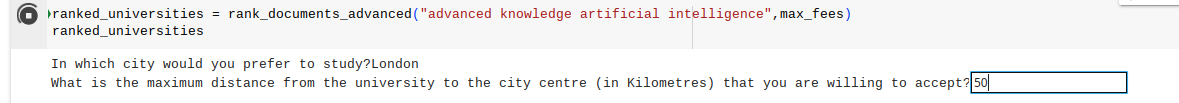

In [51]:
ranked_universities = rank_documents_advanced("advanced knowledge artificial intelligence",max_fees)

In which city would you prefer to study?London
What is the maximum distance from the university to the city centre (in Kilometres) that you are willing to accept?50
The distance from your specified location is 275.01 Km
Uni_fees / Max_fees = 0.09945091733663163
Uni_fees = 36182.73
Newmetric = -4.230190668966935
-3.742245522844067
The distance from your specified location is 2.89 Km
Uni_fees / Max_fees = 0.06713312719027005
Uni_fees = 24424.71
Newmetric = 0.9752253378363727
0.9466759509578898
The distance from your specified location is 278.7 Km
Uni_fees / Max_fees = 0.0348153095581667
Uni_fees = 12666.68
Newmetric = -4.592602517446466
-4.33960147561876
The distance from your specified location is 152.07 Km
Uni_fees / Max_fees = 0.002497519411805126
Uni_fees = 908.66
Newmetric = -2.086028425840578
-2.086028425840578
The distance from your specified location is 559.22 Km
Uni_fees / Max_fees = 0.06135169380883666
Uni_fees = 22321.28
Newmetric = -10.019369760034404
-9.467414528089979
The d

Add to the ranked_universities dataframe fees,cities and countries, for the next question

In [53]:

ranked_universities["fees"] = raw_fees['fees (USD)']  #add fees to the dataframe
ranked_universities["country"] = df["country"] #add country to the dataframe
ranked_universities["city"] = df["city"] #add city to the dataframe


In [54]:
ranked_universities

,courseName,universityName,description,url,Similarity,fees,country,city
4589,Master of Management in Artificial Intelligence,York University (Canada),"Looking for Coders, Innovators and AI Visionar...",https://www.findamasters.com/masters-degrees/c...,0.94668,13.66,Canada,Toronto
1913,Electronics Engineering,Linköping University,This programme focuses on the design of integr...,https://www.findamasters.com/masters-degrees/c...,0.87478,1118.90,Sweden,Linkoping
5775,Artificial Intelligence MSc,University of Huddersfield,"In the UK, we have seen a huge expansion in ar...",https://www.findamasters.com/masters-degrees/c...,-2.08603,6984.96,United Kingdom,Huddersfield
1356,Data Science with Artificial Intelligence MSc,University of Exeter,Overview\nDesigned for those interested in lea...,https://www.findamasters.com/masters-degrees/c...,-3.74225,19172.56,United Kingdom,Exeter
5749,Artificial Intelligence (MSc),Queen’s University Belfast,In the last decade the advances in Artificial ...,https://www.findamasters.com/masters-degrees/c...,-3.90118,6840.11,United Kingdom,Belfast
5774,Artificial Intelligence MSc,University of East London,This programme is designed for those who want ...,https://www.findamasters.com/masters-degrees/c...,-4.33960,9949.48,United Kingdom,London
5140,Advanced Computer Science (Artificial Intell...,University of Leeds,From software agents used in networking system...,https://www.findamasters.com/masters-degrees/c...,-9.46741,39958.32,United Kingdom,Leeds


### Performance review

The new metric works in a different way from the original, and the output can be interpreted in the following way:
- If different universities are in the same radius specified by the user, the ranking will be more precise than the original one, since the higher overall score will be destined for the universities with the highest value in each parenthesis.
- If the university is far from the specified location, its score will be lower, so is is indeed a very important metric to consider.

### EX 4

### For this visualization task we used the Folium library, with the geolocator Nominatim.

- The first one gives us the OpenStreetMap with marked coordinates, colors and information about the Master courses.
- The second one let us compute the coordinates of every university, and the geodesic distance between two points (which are the city where the student wants to study and the university)

Following the same line of argument as point Q3, the student will be asked to input the city where he is most likely to study (and this will centre the map on the specified city, with a certain zoom). The map will then show the universities, sorted by color and with a legend on the top right corner:
- The greener the "Circle Marker" the less fees the student has to pay (Also take into consideration how some values of the fees have been processed in point Q3)

Note that the map is interactive, you can zoom in and out, and will show the following information if you click on a marker:
- University
- Country
- City
- Course Name
- Fees
- Distance from the user input
- The new personalized score, so that the student can evaluate every option in the map

In [55]:
ranked_universities = ranked_universities.sort_values(by=['fees'], ascending=True) #sort ranked_universities by fees, from lowest to highest, so that the map will show the cheapest universities first.

In [56]:
coordinates = []
university_list = []

for element in ranked_universities.universityName:
    univ = element
    university_list.append(univ)
    loc = geolocator.geocode(univ) #we need to offset the coordinates by a random factor so that if two Msc are from the same university they are shown in the map
    offset_univ_coordinates = (loc.latitude + np.random.uniform(10**(-3), 10**(-3.5)),loc.longitude + np.random.uniform(10**(-3), 10**(-3.5))) #offest the coordinates by a random factor
    coordinates.append(offset_univ_coordinates) #add the coordinates to a list

print(coordinates)
print(university_list)

[(43.77425655876534, -79.49923349249802), (58.39831945548948, 15.576210123517445), (54.5846171970088, -5.933219591282521), (53.643386901054626, -1.777839164701076), (51.54485896651972, 0.01052423335520395), (50.737356467216664, -3.5338223264703847), (53.807468876760446, -1.5555763363512314)]
['York University (Canada)', 'Linköping University', 'Queen’s University Belfast', 'University of Huddersfield', 'University of East London', 'University of Exeter', 'University of Leeds']


In [57]:
ranked_universities = ranked_universities.reset_index() #reindex ranked_universities, so that Foliun works properly

In [58]:

initial_test = input() #ask the user to input the city where he/she would like to study

initial_coordinates = geolocator.geocode(initial_test) #get coordinates
initial_point = [initial_coordinates.latitude, initial_coordinates.longitude] #add the coordinates to a list


uni_map = folium.Map(location=initial_point, zoom_start=12) #specify the initial point (city) and the zoom level
colormap = cm.LinearColormap(colors=["darkgreen",'green','yellow','orange',"red","darkred"],index=ranked_universities.index,vmin=(min(ranked_universities.fees)),vmax=max(ranked_universities.fees)) #indexing the colormap with the index of the dataframe
colormap_show = cm.LinearColormap(colors=["darkgreen",'green','yellow','orange',"red","darkred"],vmin=(min(ranked_universities.fees)),vmax=max(ranked_universities.fees)) #remove index to show the correct colormap
folium.Circle(initial_point,radius = 5000).add_to(uni_map) #add a circle to the map, with a radius of 5km (default value, but the score funcition will take into consideration the user input), to show the maximum distance from the city that the user is willing to accept

for coordinate, idx in zip(coordinates,ranked_universities.index):
    html = '''
    <b>University: </b>{university}<br>
    <b>Country: </b>{country}<br>
    <b>City: </b>{city}<br>
    <b>Course Name:</b>{coursename}<br>
    <b>Fees: </b>{fees} $<br>
    <b>Distance from your specified location: </b>{distance} Km <br>
    <b>Score: </b>{newscore}

    '''.format(university=ranked_universities.universityName[idx],index=ranked_universities.fees,country=ranked_universities.country[idx],city=ranked_universities.city[idx],coursename=ranked_universities.courseName[idx],fees=ranked_universities.fees[idx],distance=round(distance.distance(coordinate,initial_point).km,2),newscore = ranked_universities.Similarity[idx])

    new_popup = folium.Popup(html, parse_html=False, max_width=1000) #create a popup with the function Popup, which will show the information about the university when clicked on the marker

    folium.CircleMarker(
        location=coordinate,
        fill = True,
        popup=new_popup,
        color = colormap(idx),
        fill_color = colormap(idx)
    ).add_to(uni_map)



uni_map.add_child(colormap_show)

uni_map

London


# [5] Bonus question

In [62]:
df1 = pd.read_csv('/content/drive/MyDrive/HM3-ADM/HW3_ADM/FilteredFees_DFD.tsv',sep='\t')


In [63]:
df2 = df1.copy()
df2['startDate'] = df2['startDate'].astype(str).str.split(',')
df2.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees (USD),modality,duration,city,administration,country,url
0,Air Quality Solutions - MSc,University of Leeds,Institute for Transport Studies,Full time,Up to 7 million people are estimated to die ev...,[September],35949.59,MSc,"1 year full time, 2 or 3 years part-time",Leeds,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
1,Analytical Toxicology MSc,King’s College London,Faculty of Life Sciences & Medicine,Full time,The Analytical Toxicology MSc is a unique stud...,[See Course],NaN,MSc,Full-time: One year,London,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2,Applied Computer Science and Artificial Inte...,University of Bradford,Faculty of Engineering & Digital Technologies,Full time,Computer science is the foundation of many exc...,"[September, January]",NaN,MSc,1 Year Full Time / 2 Years Part Time,Bradford,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
3,Applied Economics (Banking and Financial Mar...,University of Bath,University of Bath Online,Part time,From political uncertainty to finance and recr...,"[September, January]",902.80,MSc,2 years and 6 months full time,Bath,Online,United Kingdom,https://www.findamasters.com/masters-degrees/c...
4,Applied Linguistics - MSc,University of Glasgow,College of Arts & Humanities,Full time,This Masters focuses on how linguistic researc...,[September],NaN,MSc,1 year full-time; 2 years part-time,Glasgow,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...


Through widget we can filtering through this interface like in the following example
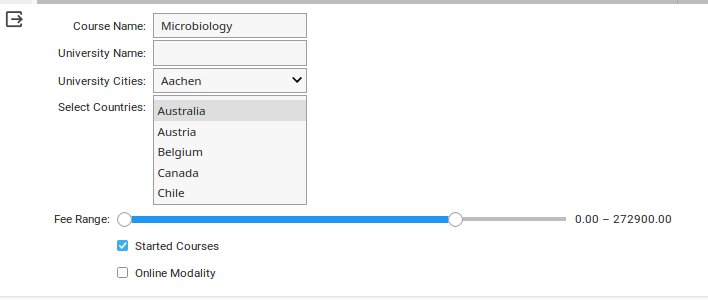

In [64]:
import ipywidgets as widgets
from IPython.display import display, Markdown

# Dropdown menu widget

course_name_widget = widgets.Text(description='Course Name:')
university_name_widget = widgets.Text(description='University Name:')
cities= sorted(df1['city'].unique().tolist())
university_city_widget = widgets.Dropdown(options=['--']+cities, description='University Cities:')
country= sorted(df1['country'].unique().tolist())
university_country_widget = widgets.Dropdown(options=country, description='University Country:')

# FloatRangeSlider for fee range
fee_range_widget = widgets.FloatRangeSlider(
    min=df1[df1['fees (USD)'].notna()]['fees (USD)'].min(),
    max=df1[df1['fees (USD)'].notna()]['fees (USD)'].max(),
    step=100,
    description='Fee Range:'
)

# Selecting multiple countries
# Get unique countries from the DataFrame
all_countries= sorted(df1['country'].unique().tolist())

# Dropdown widget allowing multiple country selections
multi_select_dropdown = widgets.SelectMultiple(
    options=country,
    value=[country[0]],
    description='Select Countries:'
)

# Global variable to store selected countries
selected_countries = set()

# Dropdown widget allowing multiple country selections
multi_select_dropdown = widgets.SelectMultiple(
    options=all_countries,
    value=[all_countries[0]],
    description='Select Countries:'
)

# Function to handle widget value change
def on_multi_select_change(change):
    global selected_countries
    selected_countries.update(change.new)

    display(Markdown(f'You selected {selected_countries}'))

# Attach the function to the widget's value change event
multi_select_dropdown.observe(on_multi_select_change, names='value')

# Checkbox widgets
started_courses_widget = widgets.Checkbox(value=False, description='Started Courses')
online_modality_widget = widgets.Checkbox(value=False, description='Online Modality')


# Adjusting widget layout for better readability
course_name_widget.style.description_width = '40%'
university_name_widget.style.description_width= '40%'
university_city_widget.style.description_width= '40%'
multi_select_dropdown.style.description_width = '40%'


# Adjusting widget layout for better readability
fee_range_widget.layout.width = '50%'

# Display widgets
display(course_name_widget, university_name_widget,university_city_widget, multi_select_dropdown, fee_range_widget, started_courses_widget, online_modality_widget)


Text(value='', description='Course Name:', style=DescriptionStyle(description_width='40%'))

Text(value='', description='University Name:', style=DescriptionStyle(description_width='40%'))

Dropdown(description='University Cities:', options=('--', 'Aachen', 'Aalborg', 'Aberdeen', 'Aberystwyth', 'Abu…

SelectMultiple(description='Select Countries:', index=(0,), options=('Australia', 'Austria', 'Belgium', 'Canad…

FloatRangeSlider(value=(90956.25, 272868.75), description='Fee Range:', layout=Layout(width='50%'), max=363825…

Checkbox(value=False, description='Started Courses')

Checkbox(value=False, description='Online Modality')

### Manual

The user can select `course name`, `university name`, a `city` between those present in the dataset, as well as countries. These last two are easy to find as they were ordered.

Contries selected are shown in ouput

>**When the user want to make a new research can rerun the precedent cell**

> When there were not enought information the entire row is selected

> When there is no match then the following message is displayed: *Try a more flexible query. Your search did not produce any result*



for pratical use we create a function to store all the selectino made by the user

In [ ]:
# Variable to store selected values
def multiple_query():
  selected_course_name = course_name_widget.value
  selected_university = university_name_widget.value
  selected_city = university_city_widget.value
  selected_country = list(selected_countries)
  selected_fee_range = fee_range_widget.value
  selected_started_courses = started_courses_widget.value
  selected_online = online_modality_widget.value
  return ([selected_course_name, selected_university, selected_city, selected_country, selected_fee_range, selected_started_courses, selected_online])
q = multiple_query()
print(q)

['Microbiology', '', 'Aachen', [], (0.0, 272900.0), True, False]


In [ ]:
# Mapping of month names to their numerical values
month_mapping = {
'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
, ' January': 1, ' February': 2, ' March': 3, ' April': 4, ' May': 5, ' June': 6,
' July': 7, ' August': 8, ' September': 9, ' October': 10, ' November': 11, ' December': 12
}

# Function to perform actions based on selected values
def extract_multiple_query(q):
    global df2  # Declare df2 as a global variable

    df3 = df2.copy()
    ##COURSE NAME
    # Check if the word for the course are in the course name
    # Set case=False to be insentive to case
    if q[0] != '':
        result = df3['courseName'].str.contains(q[0], case=False)
        # Filtering the DataFrame based on the result
        df3 = df3[result]

    ##UNIVERSITY NAME
    # Check if the word for the course are in the course name
    # Set case=False to be insentive to case
    if q[1] != '':
        result1 = df3['universityName'].str.contains(q[1], case=False)
        # Filtering the DataFrame based on the result
        df3 = df3[result1]

    # CITY AND COUNTRY
    if q[2]=='--':
        pass
    elif not q[3]:
        pass
    else:
        df3 = df3[(df3['city'] == q[2]) | df3['country'].isin(q[3])]


    # (NON)-STARTED COURSES
    # Get the current month
    current_month = datetime.now().month

    # For each row save in is_before if exists a course that will start
    for index, row in df3.iterrows():
        months = row['startDate']

        # Keeping rows where i don't have information
        if 'See Course' in months:
            continue
        if 'Any Month' in months:
            continue

        # Initialize max_start_month before the if statement
        max_start_month = 0

        # Mapping the month in the number to make comparison when a course start in a single months
        if len(months) == 1:
            starting_month = month_mapping.get(months[0], 0)

            # If q[5] is False, indicating non-started courses
            if (current_month <= starting_month) and q[5]:
                df3 = df3.loc[[index]]
            elif q[5] == False:
                df3 = df3.loc[~(df3.index == index)]

        # Search the latest begin of course when has multiple start
        elif len(months) > 1:
            l=[]
            # Taking the latest months were a course starts
            mapped_months = [month_mapping.get(elem) for elem in months if pd.notna(elem)]
            for start_month in mapped_months:
                if pd.notna(start_month):  # Skip NaN values
                    if 9 <= start_month < current_month:
                        l.append(True)
                    elif 1 <= start_month <= 7+ current_month:
                        l.append(False)
            if False in l:
                if not q[5]:  # If q[5] is False, indicating non-started courses
                    continue
                else:
                    #print('index',index)
                    df3 = df3.loc[~(df3.index == index)]

    # FEES RANGE
    for index, row in df2.iterrows():
        fees = row['fees (USD)']
        condition = (fees < q[4][1]) and (fees > q[4][0]) and (pd.isna(fees))
        # Check if DataFrame is not empty before filtering
        if not df3.empty:
            df3 = df3[df3['fees (USD)'].apply(lambda x: (x < q[4][1]) or (x > q[4][0]) or pd.isna(x))]

    ## ONLINE/ ON CAMPUS
    # Filtering only online of on campus courses
    if  q[6] ==True:
        df3 = df3[df3['administration']=='Online']
    elif q[6]==False:
        df3 = df3[df3['administration']=='On Campus']

    if not df3.empty:
        return df3[['courseName', 'universityName','url']]
    else:
        print("Try a more flexible query. Your search did not produce any result")

        ##AGGIUNGERE LA PARTE DELLA COSINE SIMILARITY CÌSE LA LISTA DEI DOCUMENTI RESTITUITI NON È VUOTA

extract_multiple_query(q)


,courseName,universityName,url
75,Biomedical Science (Medical Microbiology) - ...,Keele University,https://www.findamasters.com/masters-degrees/c...
76,Biomedical Science (Medical Microbiology) MS...,Middlesex University,https://www.findamasters.com/masters-degrees/c...
89,Biomedical Sciences - Medical Microbiology MSc,University of Westminster,https://www.findamasters.com/masters-degrees/c...
548,Clinical and Molecular Microbiology MSc/PGDi...,University of Nottingham,https://www.findamasters.com/masters-degrees/c...
1002,Microbiology and Microbiotechnology - MSc,University of Helsinki,https://www.findamasters.com/masters-degrees/c...
2204,Environmental Microbiology and Biotechnology...,Bangor University,https://www.findamasters.com/masters-degrees/c...
2574,Food Microbiology MSc,University College Cork,https://www.findamasters.com/masters-degrees/c...
4461,Master in Molecular Microbiology,University of Namur,https://www.findamasters.com/masters-degrees/c...
5607,Applied Microbiology and Biotechnology MSc,University of Wolverhampton,https://www.findamasters.com/masters-degrees/c...
5608,Applied Microbiology and Biotechnology with ...,University of Wolverhampton,https://www.findamasters.com/masters-degrees/c...


#[7] Algorithmic question

The problem involves helping Leonardo create a fake report on the number of hours he worked each day for the past d days. Leonardo has the total sum of hours he worked, the number of days, and HR limitations for each day.

## Implementation of the code

In [ ]:
# Input the total number of days and the total number of hours
total_days, sum_hours = map(int, input().split())

# Initialize a list to store the ranges of hours for each day
day_min_max = []

# Input the minimum and maximum hours for each day and create a list of ranges
for _ in range(total_days):
    min1, max1 = map(int, input().split())
    day_min_max.append([i for i in range(min1, max1 + 1)])

def find_combinations_with_sum(nested_list, target_sum):
    """
    Having a nested list with the information of the overall amount of days and hour
    worked and informationa bout mintime e maxtime for a single day, returns wether
    it it possibile to return a fake report which respect costrains
    """
    # Get the minimum and maximum hours for each day
    min_hours = [day[0] for day in day_min_max]
    max_hours = [day[-1] for day in day_min_max]

    # Check if the total hours are within the valid range
    if sum_hours >= sum(min_hours) and sum_hours <= sum(max_hours):
        print('YES')
    else:
        print('NO')

    # Iterate through all combinations of hours and print those with the target sum
    for combination in product(*nested_list):
        if sum(combination) == target_sum:
            print(*combination)

# Call the function with the provided day_min_max and sum_hours
find_combinations_with_sum(day_min_max, sum_hours)


1 1
2 3
NO



## Let's combine the time complexity of individual parts to determine the overall time complexity of the provided code:



Initializing min_hours and max_hours: O(total_days)
* Checking total hours range: O(1)
* Generating combinations: O(product of sizes of nested_list)
* Overall, the dominant factor is the third part involving the generation of combinations. Therefore, the overall time complexity is O(product of sizes of nested_list).

#### example : if we have only two working days


let's calculate the number of combinations generated by the product function for two days, each with a range of (max - min + 1) hours

day1 = max_hour - min_hour + 1 = n1

day2 = max_hour - min_hour + 1 = n2


Complexity would be : O(n1 * n2 )

## ChatGpt Implementation



both awsers are right but we think the complexity of the code that Chatgpt has been generated is better since it use backtracking algorithm which avoids generation all combination

##  **Optimality**:


The solution can be considered suboptimal in terms of time complexity, especially when the ranges for each day are large.
It generates all combinations using itertools.product, which can be inefficient for large inputs.
An improvement could be to use a backtracking algorithm that explores valid combinations more efficiently, terminating the search as soon as a valid combination is found.